# Cifar10 classification by cnn with pytorch

## 0. Import required libraries

In [1]:
from tqdm import tqdm
from time import time

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader
#from torch.autograd import Variable

import matplotlib.pyplot as plt
!matplotlib inline

/bin/bash: matplotlib: command not found


## 1. Load data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download = True, transform = transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 2. Make dataset iterable

In [4]:
batch_size = 100
num_epochs = 15
num_iters = num_epochs * (len(trainset) / batch_size) # 15 * (50000 / 100) = 15 * 500 = 7500
num_iters = int(num_iters)

print(len(trainset), num_epochs, num_iters)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 2)

50000 15 7500


## 3. Define CNN model class

#### Output Formula for Convolution
- $ O = \frac {W - K + 2P}{S} + 1$
    - $O$: output height/length
    - $W$: input height/length
    - $K$: **filter size (kernel size) = 5**
    - $P$: **same padding (non-zero)**
        - $P = \frac{K - 1}{2}  = \frac{5 - 1}{2} = 2$
    - $S$: **stride = 1**
    
#### Output Formula for Pooling
- $ O = \frac {W}{K}$
    - W: input height/width
    - K: **filter size = 2**

In [5]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.layer1 = nn.Sequential(
            # 32*32*3C  -> 32*32*64C : ((32 - 3 + 2*1) / 1) + 1 = 32 
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # 32*32*64C -> 16*16*64C : 32 / 2 = 16
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            # 16*16*64C  -> 16*16*128C : ((16 - 3 + 2*1) / 1) + 1 = 16
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 16*16*128C -> 8*8*128C : 16 / 2 = 8
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            # 8*8*128C  -> 8*8*256C : ((8 - 3 + 2*1) / 1) + 1 = 8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # 8*8*256C -> 4*4*256C : 8 / 2 = 4
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            # 4*4*256C  -> 4*4*512C : ((4 - 3 + 2*1) / 1) + 1 = 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            # 4*4*512C -> 2*2*512C : 4 / 2 = 2
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer5 = nn.Sequential(
            nn.Linear(2*2*512, 2*2*512),
            nn.ReLU(),

            nn.Linear(2*2*512, 2*2*512),
            nn.ReLU(),

            nn.Linear(2*2*512, 10),
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.view(out.size(0), -1)
        out = self.layer5(out)
        
        return out

## 4. Generate instances of model, loss, optimizer
* Model: MyModel() defined at step 3
* Loss: nn.CrossEntropyLoss()
* Optimizer: torch.optim.Adam() 

In [6]:
learning_rate = 0.0025

model = MyModel().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 5. Train

  0%|          | 0/15 [00:00<?, ?it/s]


<Hyper Parameters>
batch_size: 100, num_epochs: 15, learning_rate : 0.0025


  7%|▋         | 1/15 [00:31<07:24, 31.74s/it]

 Loss: 1.865. Accuracy: 26.880


 13%|█▎        | 2/15 [01:04<06:57, 32.09s/it]

 Loss: 1.329. Accuracy: 46.230


 20%|██        | 3/15 [01:39<06:34, 32.88s/it]

 Loss: 1.010. Accuracy: 62.370


 27%|██▋       | 4/15 [02:12<06:02, 32.99s/it]

 Loss: 0.718. Accuracy: 69.630


 33%|███▎      | 5/15 [02:46<05:32, 33.22s/it]

 Loss: 0.859. Accuracy: 74.030


 40%|████      | 6/15 [03:19<04:59, 33.31s/it]

 Loss: 0.515. Accuracy: 77.710


 47%|████▋     | 7/15 [03:53<04:26, 33.34s/it]

 Loss: 0.566. Accuracy: 78.790


 53%|█████▎    | 8/15 [04:26<03:53, 33.37s/it]

 Loss: 0.407. Accuracy: 81.390


 60%|██████    | 9/15 [05:00<03:20, 33.40s/it]

 Loss: 0.283. Accuracy: 82.780


 67%|██████▋   | 10/15 [05:33<02:47, 33.45s/it]

 Loss: 0.562. Accuracy: 82.520


 73%|███████▎  | 11/15 [06:07<02:14, 33.53s/it]

 Loss: 0.218. Accuracy: 83.810


 80%|████████  | 12/15 [06:41<01:40, 33.55s/it]

 Loss: 0.260. Accuracy: 84.410


 87%|████████▋ | 13/15 [07:14<01:07, 33.59s/it]

 Loss: 0.231. Accuracy: 84.510


 93%|█████████▎| 14/15 [07:48<00:33, 33.59s/it]

 Loss: 0.243. Accuracy: 83.990


100%|██████████| 15/15 [08:21<00:00, 33.46s/it]

 Loss: 0.177. Accuracy: 84.680
8.4 minutes elapsed


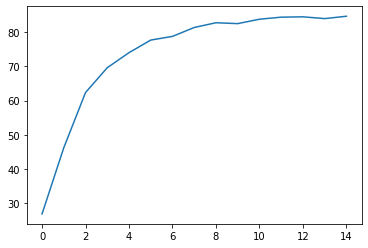

In [7]:
start_time = time()
iter = 0
accuracy_list = []

print('\n<Hyper Parameters>\nbatch_size: %d, num_epochs: %d, learning_rate : %.4f'
      % (batch_size, num_epochs, learning_rate))

for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(trainloader):
        images = images.cuda()
        labels = labels.cuda()
        
        # Clear gradients with respect to parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in testloader:
                images = images.cuda()
                labels = labels.cuda()
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            accuracy_list.append(accuracy)
            
            # Print Loss
            print(' Loss: %.3f. Accuracy: %.3f' % (loss.item(), accuracy))

plt.plot(accuracy_list)
elapsed_time = time() - start_time
print('%.1f minutes elapsed' % (elapsed_time/60))